# Teacher: Initialization
Defines the **Imports** and **Device** for the practice. More details in each subsection.

## Imports
The following code cell determines the available packages/libraries.

**You CANNOT add any other import, neither here nor anywhere else in the code.**

In [98]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Device
Checks if there is a GPU for training the neural networks. If not, the CPU will be used. It is recommended to first test if the preprocessing and model definition are correct in a CPU-based environment and then switch to the GPU-based environment for training.

In [99]:
if torch.cuda.is_available():
  DEVICE = "cuda"
  print("There is GPU available. Printing GPU information:")
  !nvidia-smi
else:
  DEVICE = "cpu"
  print("There is no GPU available, using CPU.")

There is no GPU available, using CPU.


# Teacher: Base code
<a name="base_code"></a>

Code available for use in the `Student` sections.

## Data loading
This loads the `CarsData.csv` file (available in Moodle) as a Pandas dataframe. **The file must first be loaded into the environment folder** 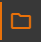. If you use a web browser *other* than Google Chrome, the loading may fail (e.g., the loading circle is red and never ends).

This dataset will be used for the **Manufacturer classification task**, where the machine learning model aims to predict/output the Manufacturer of a car using the rest of features as inputs.

The dataset was extracted from [this website](https://www.kaggle.com/datasets/meruvulikith/90000-cars-data-from-1970-to-2024/data). The dataframe to be used in practice is a 25% subsample of the full dataset, different from that of other students.

In [100]:
LABEL_COL_NAME = "Manufacturer" # Global constant

def data_loading(file_name):
  original_df = pd.read_csv(file_name)
  original_df = original_df.drop(columns=["model"]) # Model column is not available
  original_df

  # Infer column types
  infer_type = lambda x: x if pd.api.types.is_numeric_dtype(x) else pd.Categorical(x)
  original_df = original_df.apply(infer_type, axis=0)

  # Select subset
  frac=0.25
  random_seed = hash(STUDENT_NAME) % (2**32-1) # Seed must be between 0 and 2**32 - 1
  student_df = original_df.sample(frac=frac, random_state=random_seed).reset_index()
  student_df = student_df.drop(columns=["index"])

  return student_df

## Analysis
Functions that facilitate the data distribution analysis for the [Student: Exploratory data analysis](#data_analysis) section.

In [101]:
def feature_histogram(df, column_name):
    column_data = df[column_name]

    if pd.api.types.is_numeric_dtype(column_data):
        plt.hist(column_data, bins=10)
    else:
        value_counts = column_data.value_counts()
        value_counts.plot(kind='bar')

    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(column_name))
    plt.show()


def feature_stats(df, column_name, verbose=True):
  stats = {}
  column_data = df[column_name]

  # Numerical
  if pd.api.types.is_numeric_dtype(column_data):
    stats["Min"] = column_data.min()
    stats["Max"] = column_data.max()
    stats["Mean"] = column_data.mean()
    stats["Std"] = column_data.std()

  # Categorical
  elif pd.api.types.is_categorical_dtype(column_data):
    stats["Unique"] = column_data.value_counts()

  if verbose and len(stats) > 0:
    stats_str = ""
    for name, value in stats.items():
      stats_str += f" {name}={value} |"
    print(f"Stats of {column_name}:{stats_str}")

  return stats


def features_relationship(df, column_name_1, column_name_2):
    data1 = df[column_name_1]
    data2 = df[column_name_2]

    # Both columns are numerical
    if pd.api.types.is_numeric_dtype(data1) and pd.api.types.is_numeric_dtype(data2):
        plt.scatter(data1, data2)
        plt.xlabel(column_name_1)
        plt.ylabel(column_name_2)
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # Both columns are categorical
    elif pd.api.types.is_categorical_dtype(data1) and pd.api.types.is_categorical_dtype(data2):
        cross_table = pd.crosstab(data1, data2)
        cross_table.plot(kind='bar', stacked=True)
        plt.xlabel(column_name_1)
        plt.ylabel('Frequency')
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # A column is numerical and the other categorical
    else:
        # Check which is which
        if pd.api.types.is_categorical_dtype(data1):
            categorical_column = column_name_1
            numerical_column = column_name_2
        else:
            categorical_column = column_name_2
            numerical_column = column_name_1

        # Get data
        categorical_data = df[categorical_column]
        numerical_data = df[numerical_column]

        # Convert categorical data to numeric representation
        categorical_codes = categorical_data.astype('category').cat.codes

        # Plot
        plt.scatter(numerical_data, categorical_codes)
        plt.xlabel(numerical_column)
        plt.ylabel(categorical_column)
        plt.title('Relationship between {} and {}'.format(numerical_column, categorical_column))
        plt.yticks(ticks=categorical_codes.unique(), labels=categorical_data.unique()) # Set yticks labels as category names
        plt.show()

## PyTorch dataset
Function that transforms the preprocessed dataframe into the training and test datasets using the PyTorch TensorDataset class. To be used in the [Experiments](#experiments) section.

In [102]:
def df_to_dataset(preprocessed_df, label_col_name=LABEL_COL_NAME):
  if not label_col_name in preprocessed_df.columns:
    raise Exception(f"Dataframe MUST contain the label column [{label_col_name}], preferably in the last column.")

  # Obtain inputs and labels
  columns_to_discard = [col_name for col_name in preprocessed_df.columns if col_name == label_col_name]
  x = preprocessed_df.drop(columns=columns_to_discard)
  y = preprocessed_df[label_col_name]

  # Encode labels (string to identifier integer)
  label_encoder = LabelEncoder()
  y = label_encoder.fit_transform(y)

  # Convert data to PyTorch tensors
  x_tensor = torch.tensor(x.values, dtype=torch.float)
  y_tensor = torch.tensor(y, dtype=torch.long)

  # Train-test split: 80% train, 20% test
  x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42, shuffle=True)

  # Create PyTorch datasets
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

  # Get additional information for the model
  input_size = x_train_tensor.shape[1]
  num_classes = len(label_encoder.classes_)

  return train_dataset, test_dataset, input_size, num_classes, label_encoder

## Model
Basic function for the model creation and its movement to the corresponding DEVICE (GPU or CPU). To be used in the [Experiments](#experiments) section.

In [103]:
def create_model(model_class, input_size, num_classes, verbose=True):
  model = model_class(input_size, num_classes)
  model.to(DEVICE)

  if verbose:
    num_parameters = 0
    for layer in model.parameters():
      num_parameters += layer.nelement() * layer.element_size()
    print(f"The model has {num_parameters} parameters")

  return model

## Training
Function that trains a **model** with a **dataset**, for a **number of epochs** and using a specific **learning rate (lr)**. To be used in the [Experiments](#experiments) section.

In [104]:
def train(model, dataset, num_epochs, lr):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create PyTorch dataloader
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Set up loss evolution plot
    losses = []
    plt.ion()
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Evolution')
    line, = ax.plot([], [])

    # Training loop
    for epoch in range(num_epochs):
        # Set model to train mode
        model.train()

        epoch_loss = 0.0
        num_batches = 0

        for inputs, targets in train_loader:
            # Move data to GPU
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update epoch loss
            epoch_loss += loss.item()
            num_batches += 1

        # Update lists for loss plotting
        mean_epoch_loss = epoch_loss / num_batches
        losses.append(mean_epoch_loss)

        # Update plot
        line.set_ydata(losses)
        line.set_xdata(range(1, len(losses)+1))
        ax.relim()
        ax.autoscale_view()
        display.clear_output(wait=True)
        display.display(plt.gcf())

        # Print specific epoch info
        print(f'Epoch [{epoch+1}/{num_epochs}] | Mean epoch loss: {mean_epoch_loss:.4f}')

    # Turn off interactive mode and show plot
    plt.ioff()
    plt.close()

    return losses

## Evaluation
Functions for the result analysis of the [Experiments](#experiments) section. In particular, for the analysis of [classification accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy?hl=es-419) and [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).


In [105]:
def evaluate(model, dataset):
  # Create dataloader
  eval_loader = DataLoader(dataset, batch_size=256, shuffle=False)

  model.eval()  # Set model to evaluation mode
  with torch.no_grad():
      correct = 0
      total = 0
      all_targets = np.empty(len(dataset), dtype=int)
      all_predicted = np.empty_like(all_targets)
      for inputs, targets in eval_loader:
          # Move data to GPU
          inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

          # Forward pass
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)

          # Store targets and predicted labels
          all_targets[total:total+targets.size(0)] = targets.cpu().numpy()
          all_predicted[total:total+targets.size(0)] = predicted.cpu().numpy()

          # Update total and correct predictions
          total += targets.size(0)
          correct += (predicted == targets).sum().item()

      accuracy = correct / total

  return accuracy, all_targets, all_predicted


def plot_confusion_matrix(all_targets, all_predicted, label_encoder):
  # Calculate confusion matrix
  cm = confusion_matrix(all_targets, all_predicted)

  # Plot confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

# Student: Exploratory data analysis
<a name="data_analysis"></a>

In this section, the student will have to perform the following tasks:
* Load the dataset.
* Analyze each feature's data distribution using plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per feature) about them.
* Analyze relevant relationships between pairs of features' data distributions with plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per relationship) about them. Focus only on the important pairs to avoid overwhelming combinations.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


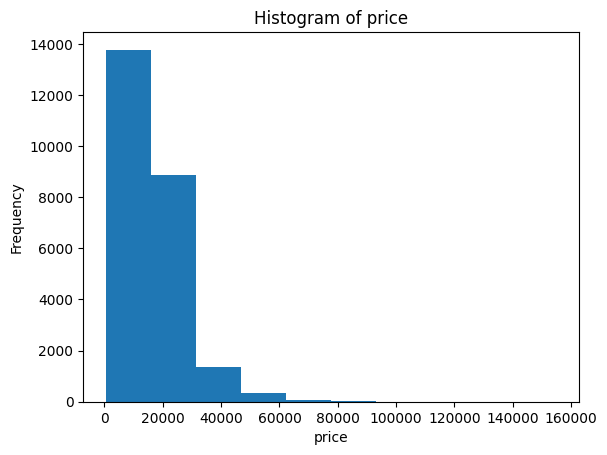

Stats of price: Min=450 | Max=154998 | Mean=16914.922629769117 | Std=10028.421679436602 |


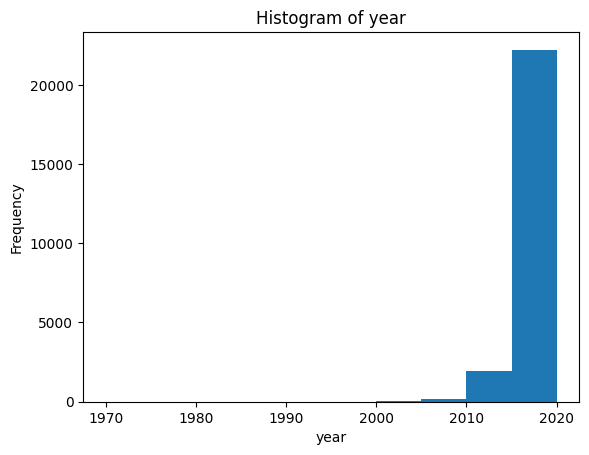

Stats of year: Min=1970 | Max=2020 | Mean=2017.087317831996 | Std=2.1446517899112187 |


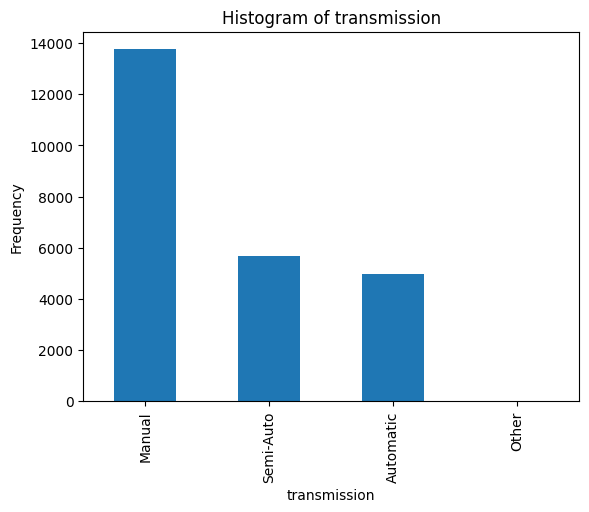

Stats of transmission: Unique=transmission
Manual       13759
Semi-Auto     5684
Automatic     4984
Other            1
Name: count, dtype: int64 |


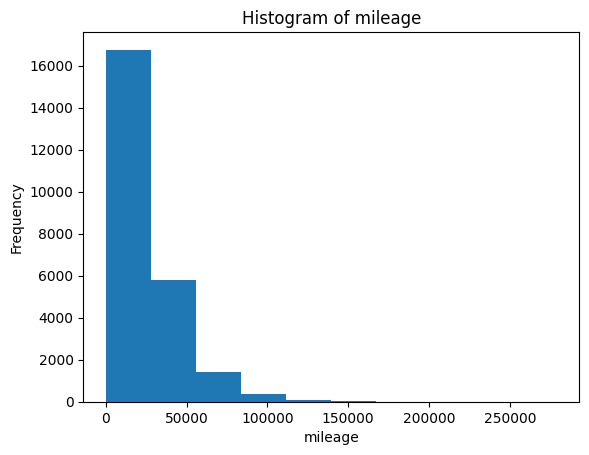

Stats of mileage: Min=1 | Max=279000 | Mean=23083.19874733912 | Std=21111.35418962946 |


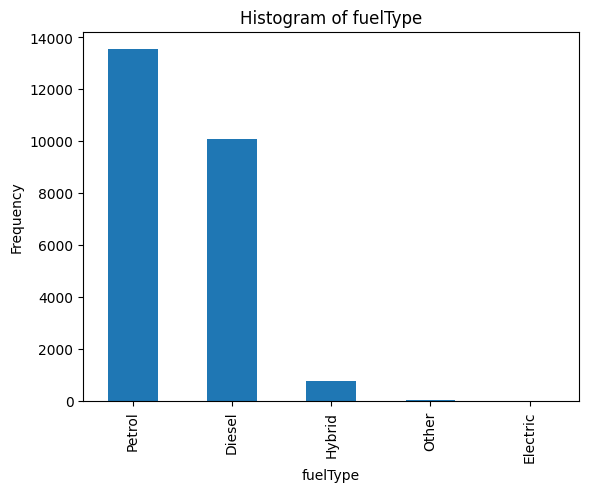

Stats of fuelType: Unique=fuelType
Petrol      13541
Diesel      10074
Hybrid        759
Other          51
Electric        3
Name: count, dtype: int64 |


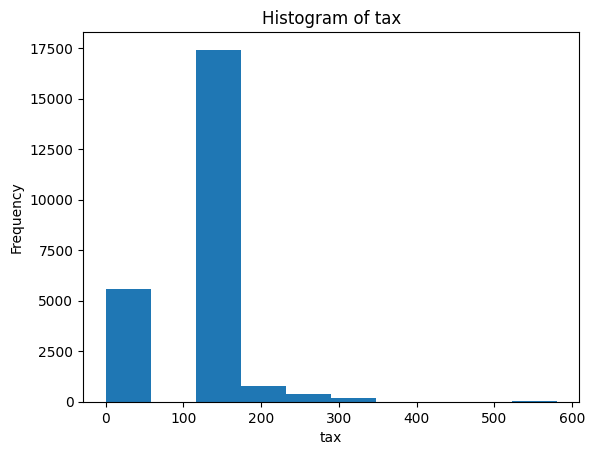

Stats of tax: Min=0 | Max=580 | Mean=121.04797773047322 | Std=63.42807579872815 |


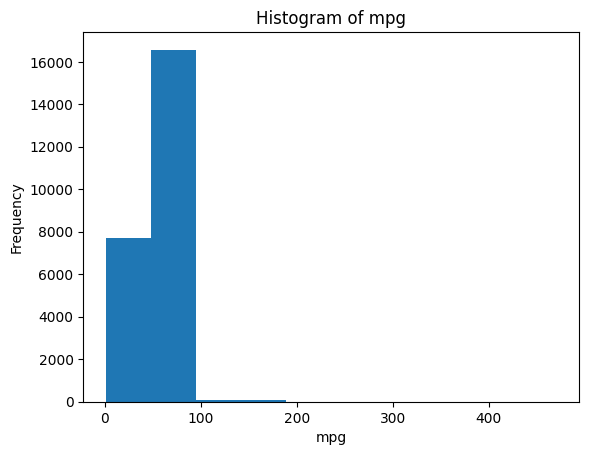

Stats of mpg: Min=1.1 | Max=470.8 | Mean=55.02710496151957 | Std=15.948924270545612 |


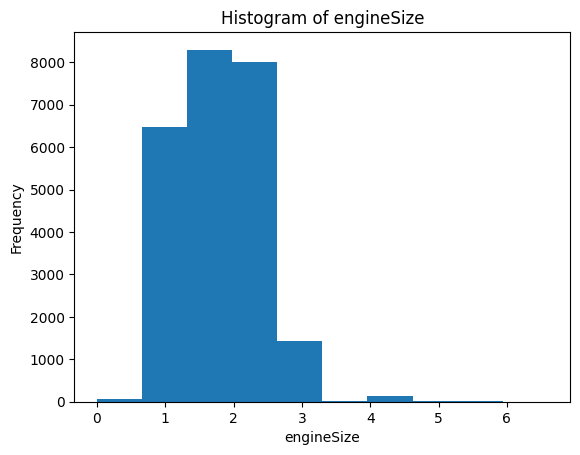

Stats of engineSize: Min=0.0 | Max=6.6 | Mean=1.6676273129196006 | Std=0.5627773736161951 |


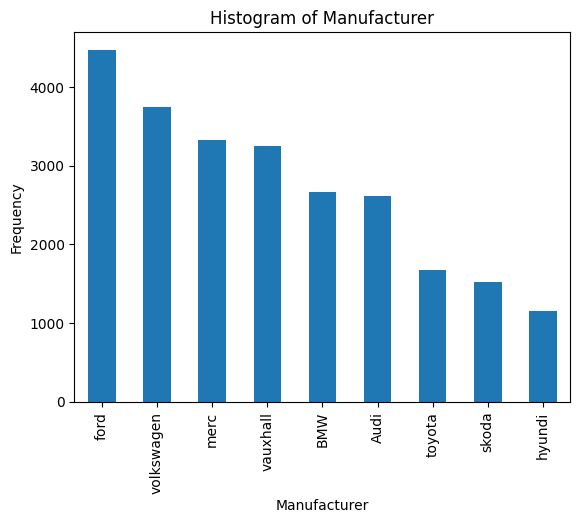

Stats of Manufacturer: Unique=Manufacturer
ford          4474
volkswagen    3745
merc          3322
vauxhall      3244
BMW           2671
Audi          2616
toyota        1676
skoda         1524
hyundi        1156
Name: count, dtype: int64 |


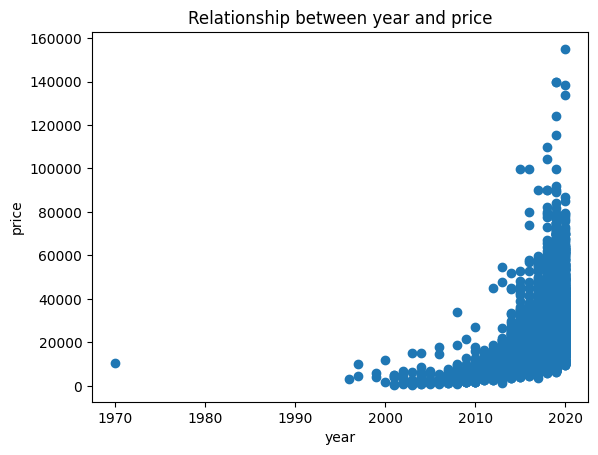

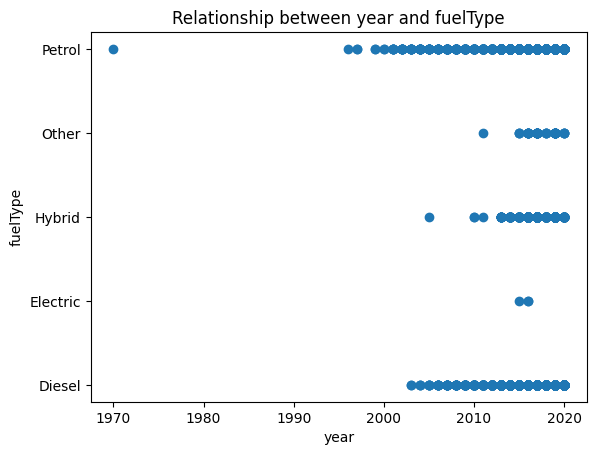

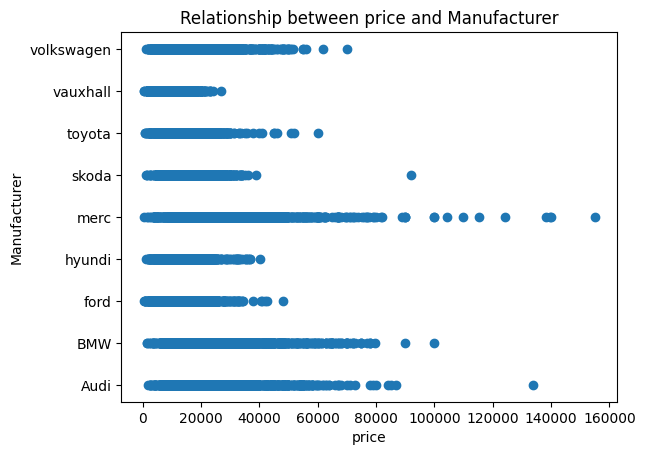

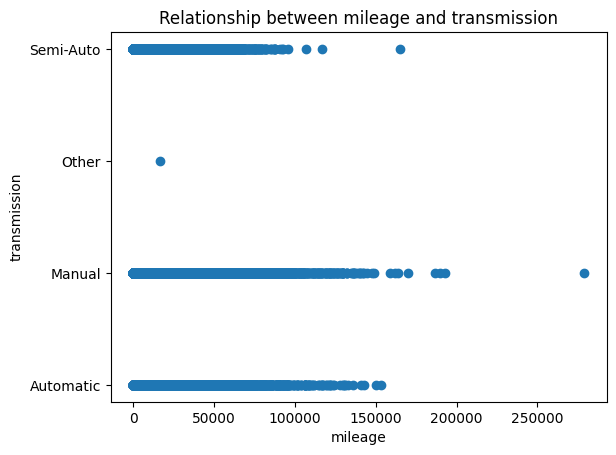

In [106]:
from google.colab import drive
drive.mount('/content/drive')
file_name = '/content/drive/MyDrive/IA_P3/CarsData.csv'

dataset = load_dataset(file_name)

feature_histogram(dataset,"price")
feature_stats(dataset,"price")

feature_histogram(dataset,"year")
feature_stats(dataset,"year")

feature_histogram(dataset,"transmission")
feature_stats(dataset,"transmission")

feature_histogram(dataset,"mileage")
feature_stats(dataset,"mileage")

feature_histogram(dataset,"fuelType")
feature_stats(dataset,"fuelType")

feature_histogram(dataset,"tax")
feature_stats(dataset,"tax")

feature_histogram(dataset,"mpg")
feature_stats(dataset,"mpg")

feature_histogram(dataset,"engineSize")
feature_stats(dataset,"engineSize")

feature_histogram(dataset,"Manufacturer")
feature_stats(dataset,"Manufacturer")

features_relationship(dataset,"year","price")

features_relationship(dataset,"year","fuelType")

features_relationship(dataset,"Manufacturer","price")

features_relationship(dataset,"transmission","mileage")



Preu:
Distribució: les dades de preus semblen estar inclinades a la esquerra. Això suggereix que hi ha relativament pocs cotxes molt cars en comparació amb la majoria dels cotxes del conjunt de dades.
Interval: els preus oscil·len entre els 450 i els 154.998 , amb una mitjana de 16.914  i una desviació estàndard de 10.028 . Això indica una àmplia gamma de preus, amb una variabilitat considerable al voltant de la mitjana.


Any:
Distribució: la distribució dels anys sembla ser relativament uniforme, la majoria dels cotxes son dels últims anys. Això suggereix que el conjunt de dades conté una col·lecció de cotxes relativament actualitzada.
Interval: els anys van del 1970 al 2020, amb una mitjana de 2017 i una desviació estàndard de 2,14. Això indica que la majoria dels cotxes són relativament nous, amb alguns atípics més antics.


Transmissió:
Distribució: La distribució dels tipus de transmissió mostra que la majoria dels cotxes tenen transmissions manuals o semiautomàtiques, amb una proporció menor amb transmissions automàtiques.
Tipus de transmissió: manual, semiautomàtica, automàtica i un altre. Manual és el tipus més comú, seguit de Semiautomàtic i després Automàtic.


Kilometratge:
Distribució: les dades de quilometratge semblen estar inclinades a la dreta, ja que la majoria dels cotxes tenen un quilometratge relativament baix. Això suggereix que la majoria dels cotxes del conjunt de dades són relativament nous o s'han conduït relativament pocs quilòmetres.
Interval: els quilometratges oscil·len entre 1 milla i 279.000 milles, amb una mitjana de 23.083 milles i una desviació estàndard de 21.111 milles. Això indica una àmplia gamma de quilometratges, amb una variabilitat considerable al voltant de la mitjana.
Tipus de combustible:


Distribució: La distribució dels tipus de combustible mostra que la majoria dels cotxes utilitzen gasolina o dièsel, amb una proporció menor que utilitzen motors híbrids o elèctrics.
Valors: gasolina, dièsel, híbrid, altres i elèctric. La gasolina i el dièsel són els tipus més comuns.

Impost:
Distribució: la distribució de les quantitats d'impostos sembla estar sesgada a la dreta, ja que la majoria dels cotxes tenen quantitats d'impostos relativament baixes. Això suggereix que la majoria dels cotxes del conjunt de dades cauen en bandes fiscals més baixes.
Interval: els imports dels impostos oscil·len entre 0 i 580 , amb una mitjana de 121  i una desviació estàndard de 63,43 . Això indica una àmplia gamma d'imports d'impostos, amb una variabilitat considerable al voltant de la mitjana.


MPG (milles per galó):
Distribució: la distribució dels valors de MPG sembla estar esbiaixada a la dreta, ja que la majoria dels cotxes tenen valors de MPG relativament alts. Això suggereix que la majoria dels cotxes del conjunt de dades són eficients en combustible.
Interval: els valors de MPG oscil·len entre 1,1 i 470,8, amb una mitjana de 55,03 i una desviació estàndard de 15,95. Això indica una àmplia gamma de valors MPG, amb una variabilitat considerable al voltant de la mitjana.



Mida del motor:
Distribució: la distribució de les mides del motor sembla ser relativament uniforme, amb la majoria dels cotxes amb cilindres d'entre 1,0 i 2,0 litres. Això suggereix que el conjunt de dades conté una gamma diversa de mides de motor.
Gamma: les mides del motor oscil·len entre 0,0 i 6,6 litres, amb una mitjana d'1,67 litres i una desviació estàndard de 0,56 litres. Això indica una àmplia gamma de mides de motor, amb una variabilitat considerable al voltant de la mitjana.


Fabricant:
Distribució: la distribució dels fabricants mostra que hi ha diversos fabricants representats al conjunt de dades, alguns són més comuns que altres.
Ford, Volkswagen, Mercedes-Benz, Vauxhall, BMW, Audi, Toyota, Skoda i Hyundai. Ford és el fabricant més comú, seguit de Volkswagen i Mercedes-Benz.



Relació preu-any:
En aquesta relació podem veure com a mida que van passant els anys els preus dels vehicles es va encarint, aixó pot ser degut  a que les noves tecnologies son mes cares o a que la inflació fa que tot valgui més diners.



Relació entre any-tipus de combustible:
Aqui podem veure com el mes antic és el de benzina, després vindira el diessel, a continuació el'hybrid, després altres tipus i finalment l'electric indicant que encara es un concepte emergent, tot i que en els ultims anys no hagi tingut molt d'exit



Relació entre el preu-fabricant
En aquesta relació podem veure com que té els vehicles més cars es mercedes seguit de audi i BMW, els més económics serien el vauxhall, l'skoda i el hyundi




Relació distancia-transmisió
Aqui podem veure com el que més es fa servir son els cotxes manuals seguits dels automatics tot i que està molt proper dels semi-automatics


# Teacher: Baseline solution
<a name="baseline"></a>
This defines the most basic (and unsuccessful) ready-to-use solution for the **Manufacturer classification task**. It includes the main components:
* Preprocessing
* Model
* Training
* Evaluation

Nonetheless, there are a lot of important things missing, as can be seen from the very poor results. Use this as inspiration for your [Solution 1A](#solution_1a), that **must** be better than this.

## Preprocessing

In [172]:
def preprocessing_0(df):
  preprocessed_df = df.copy()

  # Define columns to use and categorical
  categorical_cols = ["transmission", "fuelType"]
  columns_to_use = ["year", "price", "mileage", "tax", "mpg", "engineSize"] + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Column transformer of the features
  column_transformer = ColumnTransformer([('onehot', OneHotEncoder(), categorical_cols)],
                                         remainder='passthrough')
  preprocessed_df = pd.DataFrame(column_transformer.fit_transform(preprocessed_df))
  # IMPORTANT: Student's can't use ColumnTransformer or similars, only Pandas functions

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df = preprocessing_0(df)
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

## Model

In [173]:
class Model_0(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_0, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, num_classes),
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

model = create_model(Model_0, input_size, num_classes)

The model has 576 parameters


## Training

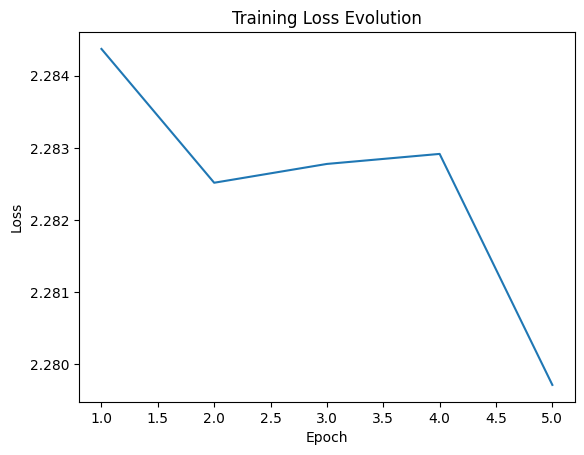

Epoch [5/5] | Mean epoch loss: 2.2797
CPU times: user 5.38 s, sys: 116 ms, total: 5.5 s
Wall time: 6.56 s


In [174]:
%%time
losses = train(model, train_dataset, num_epochs=5, lr=0.001)

## Evaluation

Train accuracy: 9.10%
Test accuracy: 8.66%


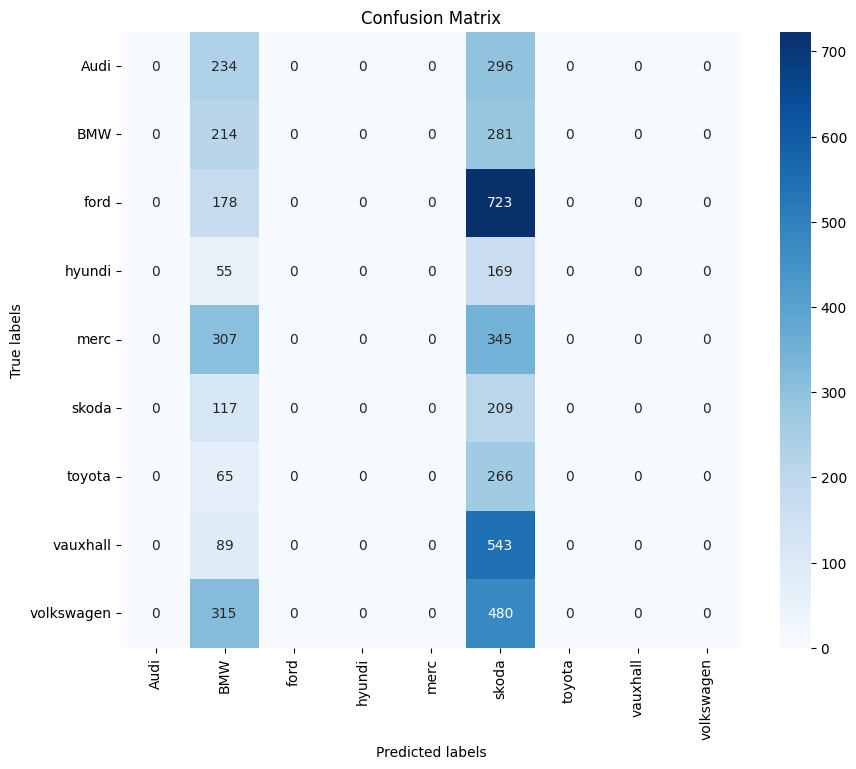

In [175]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

# Student: Experiments
<a name="experiments"></a>

In this section, the student will have to create two or three consequent solutions for the **Manufacturer classification task**. Each solution must contain the following components:
* **Idea**: What is the target/reasoning of the solution (e.g., I observed that the previous model had a very reduced size and I want to explore the effects of using a bigger model).
* **Preprocessing**: Prepare the desired features of your dataframe for the neural network. To this end, students can <font color='orange'>**only use Pandas' functions**</font>.
* **Model**: Definition of the Multi-Layer Perceptron model, **only** using [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers and
 [activations from this list](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).
* **Training**: Perform the learning process trying to maximize the results.
* **Evaluation**: Measuring the performance of the trained model.
* **Results analysis**: Examination of the solution, focusing in:
  * Training
  * Accuracy
  * Confusion matrix
  * Training time

It can be seen that these are the same as for the baseline solution, but adding the **Idea** and **Results analysis** components. An extended analysis of the baseline results will also be requested.

None of the solutions has to be the best/ideal, but all of them must be better than the [baseline](#baseline). The idea is to present consequent solutions, being each one the coherent next step of the previous one (the previous step of [Solution 1A](#solution_1a) is the [baseline](#baseline)). This does not imply that each solution has to improve the results of the previous one, but to modify at least one of the components (i.e., preprocessing or model) in a significant and coherent way.

In particular, we aim for the first two solutions ([Solution 1A](#solution_1a) and [Solution 1B](#solution_1b)) to emphasize preprocessing. Specifically, both will utilize the same basic MLP model (better than that of the [baseline](#baseline)) but experiment with two distinct preprocessing approaches. An explicit comparison of these preprocessing methods and their respective outcomes is necessary. For [Solution 2](#solution_2), the preprocessing method from one of the earlier solutions will be employed. The goal of this final solution is to enhance results by improving/refining the MLP model.

## Analysis of baseline
Provide a comprehensive analysis of the [baseline solution](#baseline). Apart from the results (i.e., **training, accuracy, confusion matrix and runtime**), a review of the solution design (i.e., **preprocessing and model**) is also required. It is not necessary to explain or analysis the code, but the choices. For instace, which features are used and how.

TODO: YOUR ANALYSIS HERE


Preprocessament:
Selecció de Característiques: Se seleccionen les característiques rellevants per al model, que inclouen "year", "price", "mileage", "tax", "mpg", "engineSize", "transmission" i "fuelType".
Codificació de Variables Categòriques: Les variables categòriques "transmission" i "fuelType" es codifiquen utilitzant la tècnica de one-hot encoding.

Normalització de Característiques: No es fa cap normalització específica per a les característiques numèriques en aquest preprocessament..

Model:
Arquitectura del Model: Sutilitza una xarxa neuronal simple amb una única capa lineal seguida duna activació softmax. La capa lineal té la mateixa mida que el nombre de classes, cosa que significa que la sortida de la xarxa és una distribució de probabilitat sobre les classes.
Activació Softmax: La funció d'activació softmax s'utilitza per normalitzar les sortides del model perquè representin probabilitats entre 0 i 1 per a cada classe.

Entrenament:
Durada de l'Entrenament: El model s'entrena durant 5 epoch amb una taxa d'aprenentatge de 0.001.

Resultats:
Els resultats no son gaire bons de epoch en epoch a vegades no hi ha millora, depén de quan s'executa, i té una fiabilitat de un 9% aproximadament, aixo amb normalitzacio o un augment de capes pot millorar dràsticament


## Common functions
For avoiding code repetition along all the solutions, you can use this subsection for your common functions and/or classes.

## Solution 1A: First preprocessing
<a name="solution_1a"></a>

Subsequent of [Baseline](#baseline), it implements a basic MLP (better than the provided at the baseline) and a first option for the preprocessing step.

In [112]:
def preprocessing_1(df):
  preprocessed_df = df.copy()

  # Define columns to use and categorical
  categorical_cols = ["transmission", "fuelType"]
  numerical_cols = ["year", "price", "mileage", "tax", "mpg", "engineSize"]
  columns_to_use =  numerical_cols + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Column transformer of the features
  for col in categorical_cols:
    #Get the one_hot_encoding for each column
    one_hot_encoding = pd.get_dummies(preprocessed_df[col])
    #Append the one_hot_encoding  columns to the preprocessed_df
    for new_col in one_hot_encoding.columns:
      preprocessed_df[new_col] = one_hot_encoding[new_col] * 1
    #Delete old columns
    del preprocessed_df[col]

  #normalize
  for col in numerical_cols:
    preprocessed_df[col] = (preprocessed_df[col] - preprocessed_df[col].min()) / (preprocessed_df[col].max() - preprocessed_df[col].min())

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df = preprocessing_1(df)
#preprocessed_df
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

In [171]:
import torch.nn.functional as F

class Model_1(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size):
        super(Model_1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # Define input layer with input_size neurons and hidden layer with hidden_size neurons
            nn.ReLU(),  # Apply ReLU activation function
            nn.Linear(hidden_size, num_classes),  # Define output layer with num_classes neurons
            nn.Softmax(dim=1)  # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)  # Forward pass through the layers

# Define the size of the hidden layer
hidden_size = 250

# Create the model with specified input size, number of classes, and hidden layer size
model = Model_1(input_size, num_classes, hidden_size)


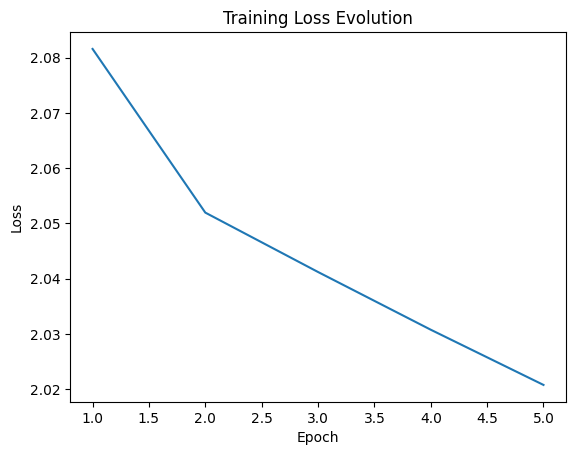

Epoch [5/5] | Mean epoch loss: 2.0208
CPU times: user 6.62 s, sys: 140 ms, total: 6.76 s
Wall time: 7.71 s


In [114]:
%%time
losses = train(model, train_dataset, num_epochs=5, lr=0.001)

Train accuracy: 36.19%
Test accuracy: 35.90%


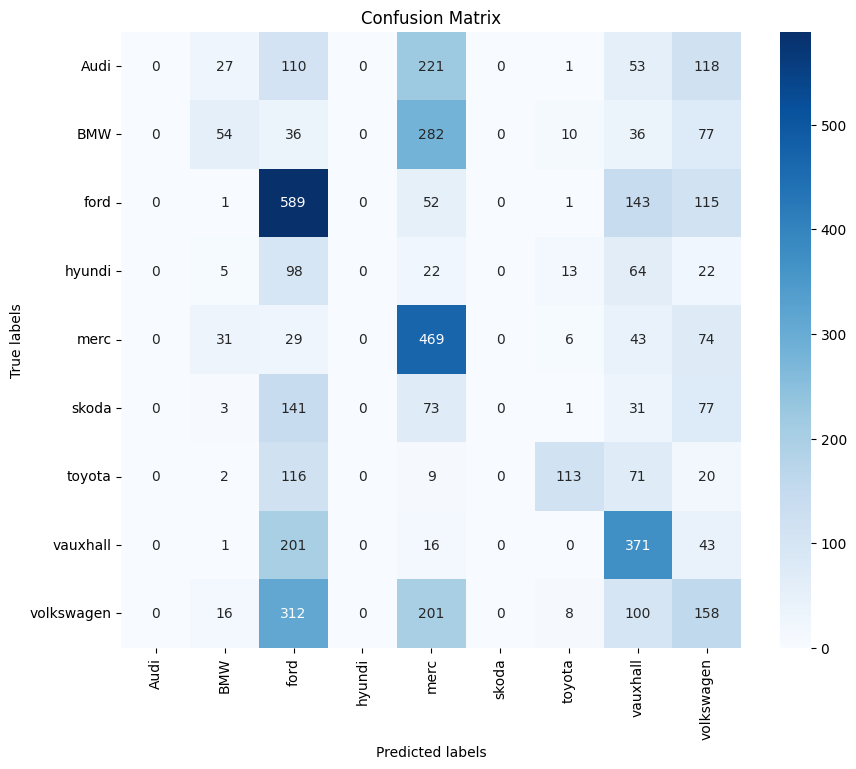

In [115]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

## Solution 1B: Second preprocessing solution
<a name="solution_1b"></a>

Subsequent of the [Solution 1A](#solution_1a), uses the same basic MLP but with an alternative preprocessing step.

In [157]:
def preprocessing_1(df):
  preprocessed_df = df.copy()

  # Define columns to use and categorical
  categorical_cols = ["transmission", "fuelType"]
  numerical_cols = ["year", "price", "mileage", "tax", "mpg", "engineSize"]
  columns_to_use =  numerical_cols + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Column transformer of the features
  for col in categorical_cols:
    #Get the one_hot_encoding for each column
    one_hot_encoding = pd.get_dummies(preprocessed_df[col])
    #Append the one_hot_encoding  columns to the preprocessed_df
    for new_col in one_hot_encoding.columns:
      preprocessed_df[new_col] = one_hot_encoding[new_col] * 1
    #Delete old columns
    del preprocessed_df[col]

    for col in numerical_cols:
        # Standardize
      preprocessed_df[col] = (preprocessed_df[col] - preprocessed_df[col].mean()) / preprocessed_df[col].std()

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df = preprocessing_1(df)
#preprocessed_df
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

In [170]:
import torch.nn.functional as F

class Model_1(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size):
        super(Model_1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # Define input layer with input_size neurons and hidden layer with hidden_size neurons
            nn.ReLU(),  # Apply ReLU activation function
            nn.Linear(hidden_size, num_classes),  # Define output layer with num_classes neurons
            nn.Softmax(dim=1)  # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)  # Forward pass through the layers

# Define the size of the hidden layer
hidden_size = 250

# Create the model with specified input size, number of classes, and hidden layer size
model = Model_1(input_size, num_classes, hidden_size)


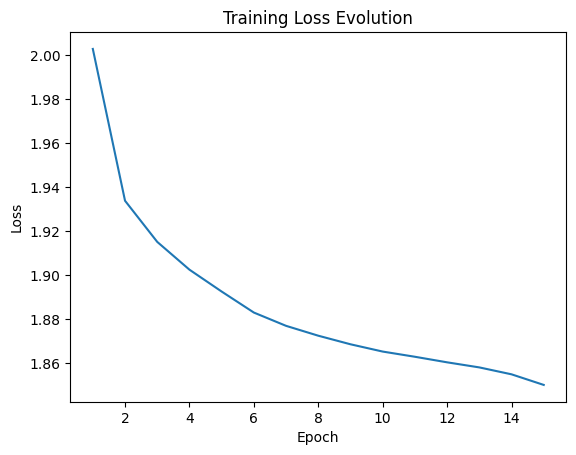

Epoch [15/15] | Mean epoch loss: 1.8500
CPU times: user 18.8 s, sys: 285 ms, total: 19 s
Wall time: 19.3 s


In [159]:
%%time
losses = train(model, train_dataset, num_epochs=15, lr=0.001)

Train accuracy: 53.01%
Test accuracy: 52.23%


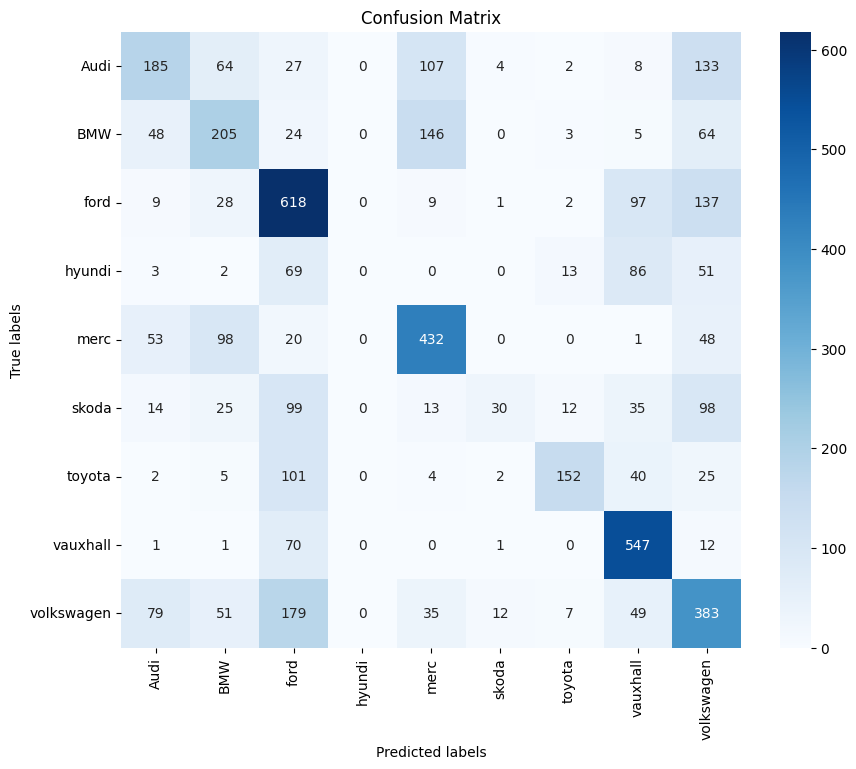

In [160]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

## Solution 2: New model solution
<a name="solution_2"></a>

Subsequent of either [Solution 1A](#solution_1a) or [Solution 1B](#solution_1b), uses the same preprocessing step but improves the MLP model.

In [165]:
def preprocessing_1(df):
  preprocessed_df = df.copy()

  # Define columns to use and categorical
  categorical_cols = ["transmission", "fuelType"]
  numerical_cols = ["year", "price", "mileage", "tax", "mpg", "engineSize"]
  columns_to_use =  numerical_cols + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Column transformer of the features
  for col in categorical_cols:
    #Get the one_hot_encoding for each column
    one_hot_encoding = pd.get_dummies(preprocessed_df[col])
    #Append the one_hot_encoding  columns to the preprocessed_df
    for new_col in one_hot_encoding.columns:
      preprocessed_df[new_col] = one_hot_encoding[new_col] * 1
    #Delete old columns
    del preprocessed_df[col]

    for col in numerical_cols:
        # Estandarizar los datos numéricos
      preprocessed_df[col] = (preprocessed_df[col] - preprocessed_df[col].mean()) / preprocessed_df[col].std()

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df = preprocessing_1(df)
#preprocessed_df
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

In [169]:
import torch.nn.functional as F

class Model_1(nn.Module):
    def __init__(self, input_size, num_classes, hidden_sizes):
        super(Model_1, self).__init__()

        # Define hidden layers with batch normalization
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_sizes[0])])
        for i in range(1, len(hidden_sizes)):
            # Create additional layers with variable sizes and batch normalization
            self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.batch_norms.append(nn.BatchNorm1d(hidden_sizes[i]))

        # Define output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)

        # Final activation
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass through hidden layers with batch normalization
        for layer, batch_norm in zip(self.hidden_layers, self.batch_norms):
            x = F.relu(batch_norm(layer(x)))

        # Forward pass through output layer
        x = self.output_layer(x)

        # Apply final activation
        x = self.softmax(x)

        return x

# Hidden layer sizes (for example)
hidden_sizes = [256, 200, 150, 100, 50]

# Create the model with batch normalization
model = Model_1(input_size, num_classes, hidden_sizes)


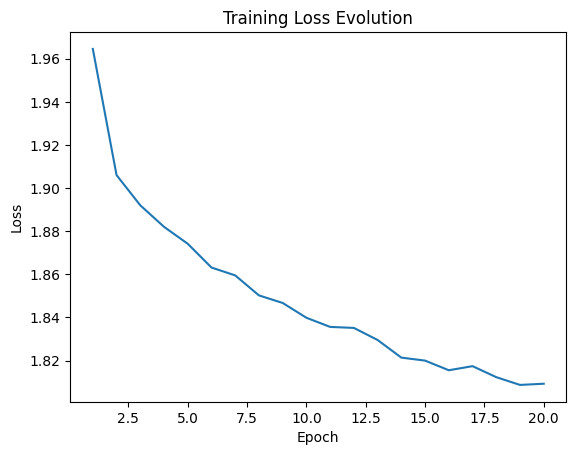

Epoch [20/20] | Mean epoch loss: 1.8093
CPU times: user 1min 9s, sys: 655 ms, total: 1min 10s
Wall time: 1min 11s


In [167]:
%%time
losses = train(model, train_dataset, num_epochs=20, lr=0.001)

Train accuracy: 58.62%
Test accuracy: 56.22%


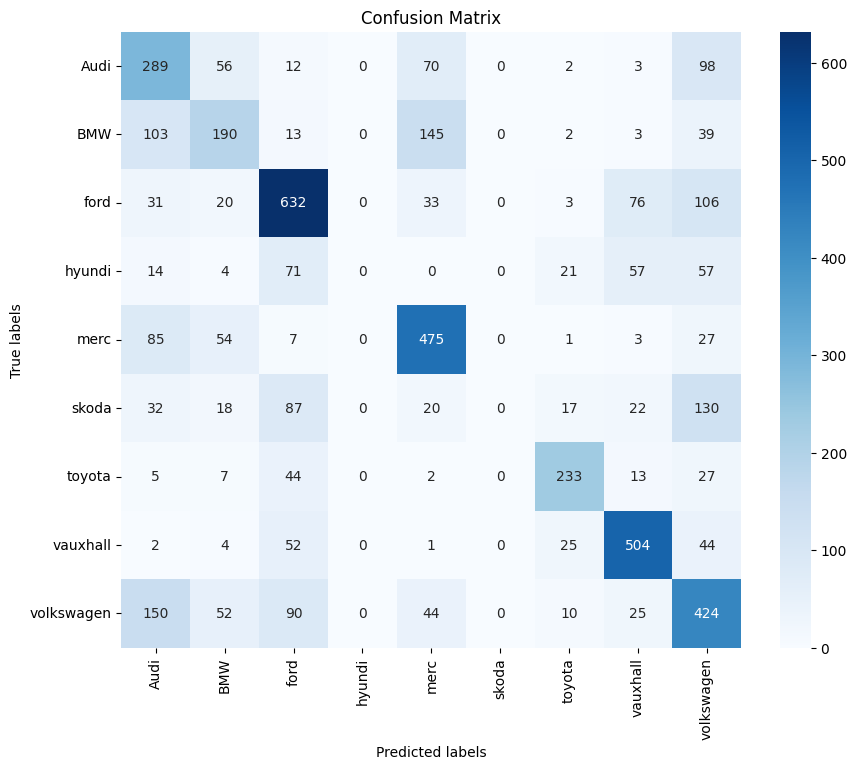

In [168]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)